# Import all libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Function to generate data

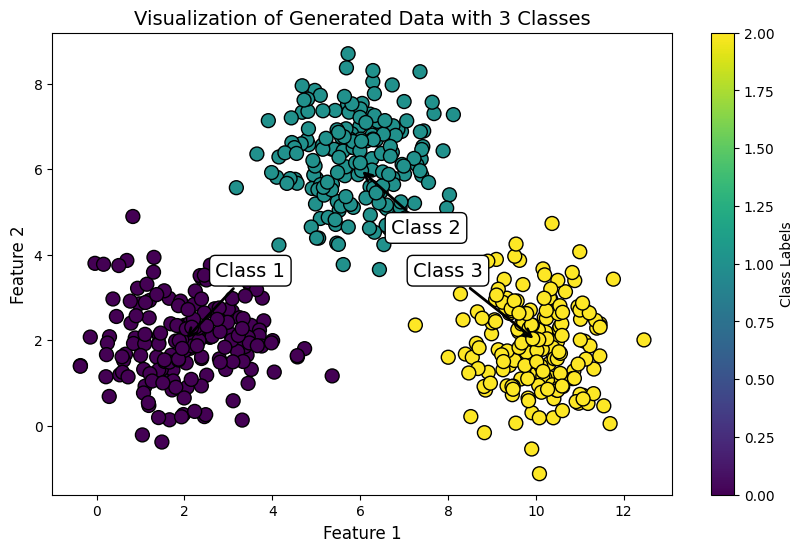

In [2]:
def generate_data(samples_per_class=180):
    np.random.seed(32)
    # Class 1: Centered at (2, 2)
    class1 = np.random.randn(samples_per_class, 2) + np.array([2, 2])
    # Class 2: Centered at (6, 6)
    class2 = np.random.randn(samples_per_class, 2) + np.array([6, 6])
    # Class 3: Centered at (10, 2)
    class3 = np.random.randn(samples_per_class, 2) + np.array([10, 2])

    # Combine the data
    X = np.vstack([class1, class2, class3])
    y = np.array([0]*samples_per_class + [1]*samples_per_class + [2]*samples_per_class)
    
    return X, y

# Generate data
X, y = generate_data()

# Plot the generated data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=100, edgecolor="k")

# Class centers for annotations
centers = [(2, 2), (6, 6), (10, 2)]
offsets = [(1.5, 1.5), (1.5, -1.5), (-2, 1.5)]  # Offset for better placement

for i, (center, offset) in enumerate(zip(centers, offsets)):
    plt.annotate(f'Class {i + 1}',  # Adjusted annotation to start from Class 1
                 xy=center, 
                 xytext=(center[0] + offset[0], center[1] + offset[1]), 
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=2), 
                 fontsize=14, 
                 color="black", 
                 ha="center",
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Adding plot details
plt.title("Visualization of Generated Data with 3 Classes", fontsize=14)
plt.colorbar(scatter, label="Class Labels")
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.show()


# Encode the class for maintaining same type of data 

In [3]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training, validation, and test sets

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=32)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=32)

# Print the sizes of the splits

In [5]:
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 324 samples
Validation set: 108 samples
Test set: 108 samples


# Define the custom neural network class

In [6]:
class NeuralNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr):
        # Initialize weights for all layers
        self.W1 = np.random.randn(input_size, hidden_size1)  # Input to Hidden Layer 1
        self.W2 = np.random.randn(hidden_size1, hidden_size2)  # Hidden Layer 1 to Hidden Layer 2
        self.W3 = np.random.randn(hidden_size2, hidden_size3)  # Hidden Layer 2 to Hidden Layer 3
        self.W4 = np.random.randn(hidden_size3, output_size)  # Hidden Layer 3 to Output Layer
        self.lr = lr

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def feed_forward(self, x):
        # Layer 1
        self.hidden_input1 = np.dot(x, self.W1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        # Layer 2
        self.hidden_input2 = np.dot(self.hidden_output1, self.W2)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)

        # Layer 3
        self.hidden_input3 = np.dot(self.hidden_output2, self.W3)
        self.hidden_output3 = self.sigmoid(self.hidden_input3)

        # Output Layer
        self.output_input = np.dot(self.hidden_output3, self.W4)
        self.output = self.sigmoid(self.output_input)
        return self.output

    def backprop(self, x, y, output):
        # Output Layer Error
        output_error = y - output
        output_delta = output_error * self.sigmoid(output, derivative=True)

        # Hidden Layer 3 Error
        hidden_error3 = np.dot(output_delta, self.W4.T)
        hidden_delta3 = hidden_error3 * self.sigmoid(self.hidden_output3, derivative=True)

        # Hidden Layer 2 Error
        hidden_error2 = np.dot(hidden_delta3, self.W3.T)
        hidden_delta2 = hidden_error2 * self.sigmoid(self.hidden_output2, derivative=True)

        # Hidden Layer 1 Error
        hidden_error1 = np.dot(hidden_delta2, self.W2.T)
        hidden_delta1 = hidden_error1 * self.sigmoid(self.hidden_output1, derivative=True)

        # Update weights
        self.W4 += np.dot(self.hidden_output3.T, output_delta) * self.lr
        self.W3 += np.dot(self.hidden_output2.T, hidden_delta3) * self.lr
        self.W2 += np.dot(self.hidden_output1.T, hidden_delta2) * self.lr
        self.W1 += np.dot(x.T, hidden_delta1) * self.lr

    def train(self, x, y):
        output = self.feed_forward(x)
        self.backprop(x, y, output)

# Train the Neural Network

In [7]:
input_size = X_train.shape[1]
hidden_size1 = 15  # Neurons in the first hidden layer
hidden_size2 = 15  # Neurons in the second hidden layer
hidden_size3 = 15  # Neurons in the third hidden layer
output_size = y_train.shape[1]  # Number of output classes
lr = 0.001  # Learning rate
epochs = 2000

nn = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    nn.train(X_train, y_train)
    train_output = nn.feed_forward(X_train)
    val_output = nn.feed_forward(X_val)

    # Compute loss
    train_loss = np.mean((y_train - train_output) ** 2)
    val_loss = np.mean((y_val - val_output) ** 2)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Compute accuracy
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_output, axis=1))
    val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_output, axis=1))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}, "
              f"Train Accuracy = {train_accuracy * 100:.2f}%, Validation Accuracy = {val_accuracy * 100:.2f}%")


Epoch 0: Train Loss = 0.3523, Validation Loss = 0.3582, Train Accuracy = 33.64%, Validation Accuracy = 32.41%
Epoch 50: Train Loss = 0.1839, Validation Loss = 0.1832, Train Accuracy = 73.77%, Validation Accuracy = 73.15%
Epoch 100: Train Loss = 0.1620, Validation Loss = 0.1610, Train Accuracy = 78.09%, Validation Accuracy = 75.93%
Epoch 150: Train Loss = 0.1409, Validation Loss = 0.1401, Train Accuracy = 85.80%, Validation Accuracy = 87.04%
Epoch 200: Train Loss = 0.1210, Validation Loss = 0.1210, Train Accuracy = 91.36%, Validation Accuracy = 87.96%
Epoch 250: Train Loss = 0.1035, Validation Loss = 0.1044, Train Accuracy = 94.75%, Validation Accuracy = 90.74%
Epoch 300: Train Loss = 0.0877, Validation Loss = 0.0893, Train Accuracy = 96.30%, Validation Accuracy = 91.67%
Epoch 350: Train Loss = 0.0733, Validation Loss = 0.0755, Train Accuracy = 96.30%, Validation Accuracy = 92.59%
Epoch 400: Train Loss = 0.0612, Validation Loss = 0.0639, Train Accuracy = 97.53%, Validation Accuracy = 94

# Visualize Loss and Accuracy

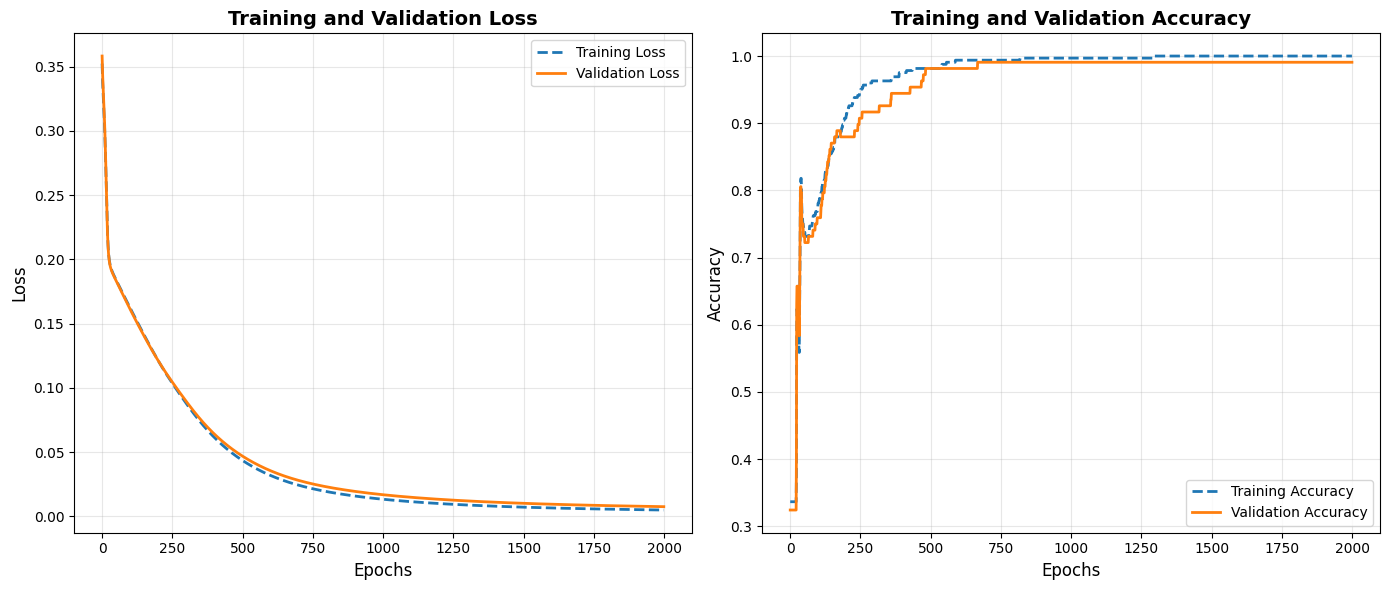

In [8]:
plt.figure(figsize=(14, 6))

# Subplot 1: Training and Validation Loss

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", linestyle='--', linewidth=2)
plt.plot(val_losses, label="Validation Loss", linestyle='-', linewidth=2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Subplot 2: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", linestyle='--', linewidth=2)
plt.plot(val_accuracies, label="Validation Accuracy", linestyle='-', linewidth=2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Adjust layout for better presentation
plt.tight_layout()
plt.show()


# Evaluate the Model

In [9]:
test_output = nn.feed_forward(X_test)
predicted_classes = np.argmax(test_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)

# Compute accuracy

In [10]:
test_accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 100.00%


# Plot Actual Vs Predicted

/tmp/ipykernel_1082/2897181033.py:11: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter_actual = plt.scatter(X_test[:, 0], X_test[:, 1],


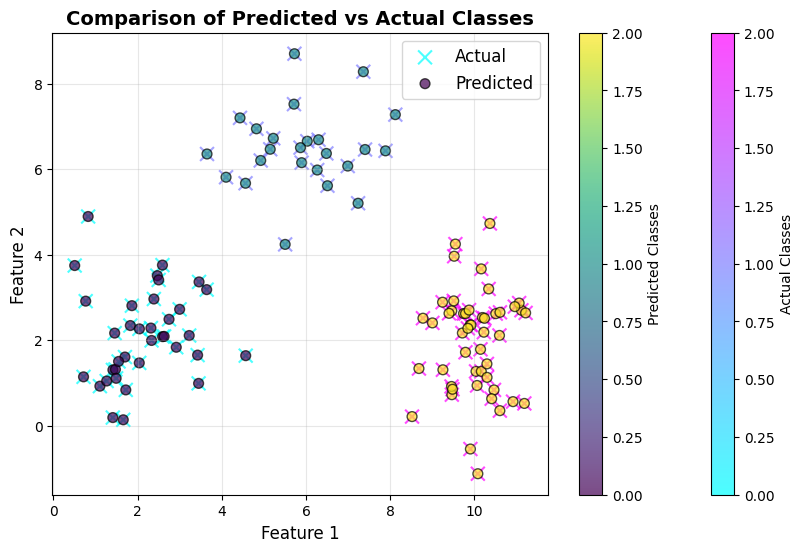

In [11]:
predicted_output = nn.feed_forward(X_test)

# Convert predicted output and actual labels to class labels
predicted_classes = np.argmax(predicted_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)

# Visualize the Comparison using different colors and markers for better distinction
plt.figure(figsize=(10, 6))

# Create a scatter plot for actual classes using color coding
scatter_actual = plt.scatter(X_test[:, 0], X_test[:, 1], 
                             c=actual_classes, cmap='cool', 
                             s=100, marker='x', alpha=0.7, edgecolor='k', label='Actual')

# Overlay predicted classes with different color map and marker
scatter_predicted = plt.scatter(X_test[:, 0], X_test[:, 1], 
                                c=predicted_classes, cmap='viridis', 
                                s=50, marker='o', alpha=0.7, edgecolor='k', label='Predicted')

# Add plot details and labels
plt.title("Comparison of Predicted vs Actual Classes", fontsize=14, fontweight='bold')
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Add legend for clarity
plt.legend(loc="best", fontsize=12)

# Display a grid for better readability
plt.grid(True, alpha=0.3)

# Add colorbar to map the color to class labels
plt.colorbar(scatter_actual, label="Actual Classes")
plt.colorbar(scatter_predicted, label="Predicted Classes")

# Show the plot
plt.show()


# Decision Boundary Plot

/tmp/ipykernel_1082/3838545886.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='cool', s=100, marker='x', alpha=0.7, edgecolor='k', label='Actual')


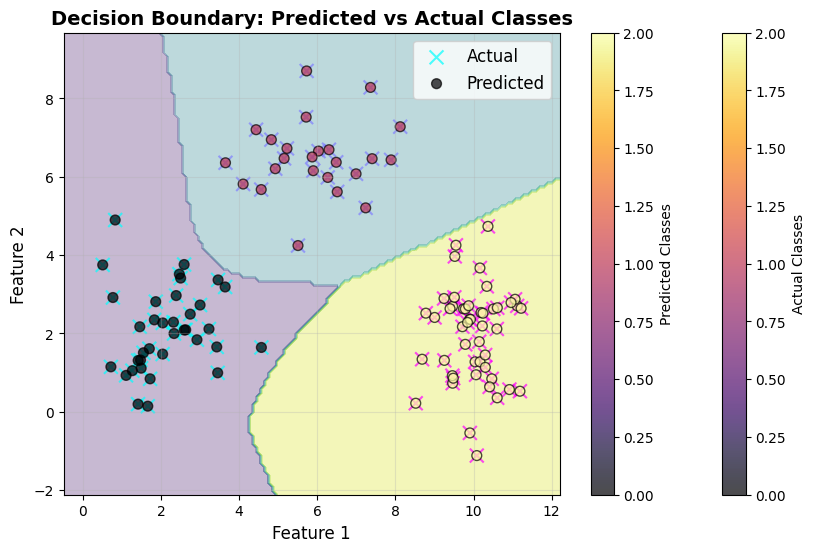

In [12]:
# Predict output from the neural network
predicted_output = nn.feed_forward(X_test)

# Convert predicted output and actual labels to class labels
predicted_classes = np.argmax(predicted_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)

# Generate meshgrid for decision boundary plotting
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict the class for each point in the meshgrid to visualize decision boundary
Z = np.argmax(nn.feed_forward(np.c_[xx.ravel(), yy.ravel()]), axis=1)
Z = Z.reshape(xx.shape)

# Visualize the comparison using contour plot and scatter plot
plt.figure(figsize=(10, 6))

# Plot decision boundary (contour plot)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

# Scatter plot for actual test classes
plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='cool', s=100, marker='x', alpha=0.7, edgecolor='k', label='Actual')

# Overlay predicted classes using a different marker and color map
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='inferno', s=50, marker='o', alpha=0.7, edgecolor='k', label='Predicted')

# Add plot details and labels
plt.title("Decision Boundary: Predicted vs Actual Classes", fontsize=14, fontweight='bold')
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Add legend for clarity
plt.legend(loc="best", fontsize=12)

# Display grid for better readability
plt.grid(True, alpha=0.3)

# Add colorbars for both actual and predicted classes
plt.colorbar(label="Actual Classes")
plt.colorbar(label="Predicted Classes")

# Show the plot
plt.show()